In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.api import proportion_confint
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from scipy.stats import beta

## Summary
This notebook presents an analysis of an e-commerce A/B experiment evaluating whether a new product experience improves user conversion.

Conversion behavior is analyzed using multiple approaches: frequentist hypothesis testing, non-parametric bootstrap uncertainty estimation, logistic regression with covariate adjustment and interaction terms, and Bayesian A/B testing.

Across all methods, results are highly consistent. The estimated treatment effect on conversion is small, directionally negative, and statistically indistinguishable from zero. Bootstrap confidence intervals and Bayesian credible intervals are narrow and centered around zero, indicating that the absence of improvement is not due to insufficient data but reflects the true lack of a meaningful effect. Segment-level analyses by country reveal no reliable heterogeneous treatment effects after proper correction for multiple testing.

From a business perspective, the treatment exhibits negative expected value at scale. Under realistic assumptions, rollout would be expected to reduce daily conversions, with limited upside even under optimistic scenarios. Consequently, neither a global nor a targeted rollout is justified.

In [2]:
countries = pd.read_csv("/kaggle/input/ecommerce-ab-testing-2022-dataset1/ecommerce_ab_testing_2022_dataset1/countries.csv")
df = pd.read_csv("/kaggle/input/ecommerce-ab-testing-2022-dataset1/ecommerce_ab_testing_2022_dataset1/ab_data.csv")

df = df.merge(countries, on="user_id", how="left")
mask = ((df.group=='control') & (df.landing_page=='old_page')) | ((df.group=='treatment') & (df.landing_page=='new_page'))
df = df[mask].copy()
df = df.sort_values('timestamp').drop_duplicates('user_id', keep='first')
df.head()

,user_id,timestamp,group,landing_page,converted,country
123148,653457,00:00.0,control,old_page,0,UK
53529,825480,00:00.0,control,old_page,0,US
45680,817555,00:00.0,control,old_page,0,US
30513,799074,00:00.0,treatment,new_page,0,US
128342,731946,00:00.0,control,old_page,0,UK


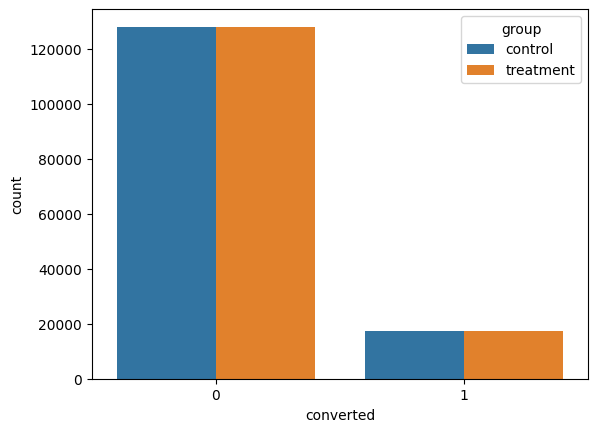

In [3]:
sns.countplot(data=df, x="converted", hue="group")
plt.show()

The distribution of conversions suggests no apparent uplift for the treatment group. Any difference appears small relative to sampling variability, motivating formal statistical testing.


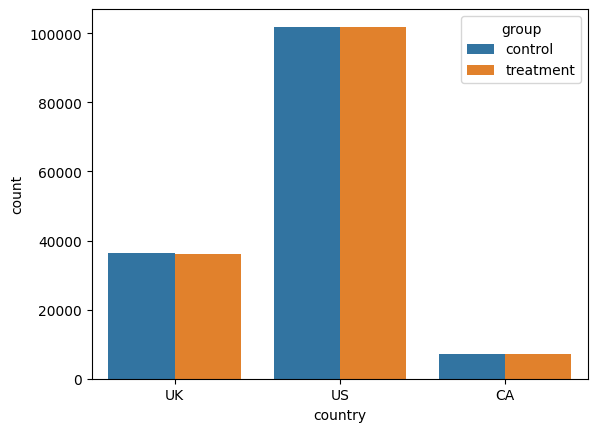

In [4]:
sns.countplot(data=df, x="country", hue="group")
plt.show()

- US accounts for the majority of traffic.

- UK contributes a moderate share.

- CA has a relatively small sample size.

- Within each country, control and treatment samples are well balanced.

## Sample Ratio Mismatch (SRM) Check

Before analyzing treatment effects, we verify that traffic was split as intended.

We test:
$$
H_0: P(\text{Control}) = P(\text{Treatment}) = 0.5
\quad \text{vs} \quad
H_1: P(\text{Control}) \neq P(\text{Treatment})
$$

using a chi-square goodness-of-fit test.


In [5]:
df['group'].value_counts().reindex(['control','treatment'])

group
control      145274
treatment    145311
Name: count, dtype: int64

In [6]:
counts = df['group'].value_counts().reindex(['control','treatment']).values
expected = np.array([0.5, 0.5]) * counts.sum()
chi2, p = chisquare(counts, f_exp=expected)
f"{chi2:.3f}, {p:.2f}"

'0.005, 0.95'

We fail to reject $H_0$, indicating no evidence of sample ratio mismatch. The observed allocation is consistent with proper randomization.


## One-Sided Test for Conversion Uplift

We test whether the treatment improves conversion:

$$
H_0: p_T \le p_C
\quad \text{vs} \quad
H_1: p_T > p_C
$$

using a one-sided z-test for proportions.


In [7]:
groups = df.groupby('group')['converted']
n = groups.count()
x = groups.sum()

p_hat = x / n
lift = p_hat['treatment'] - p_hat['control']
rel_lift = lift / p_hat['control']

z, p = proportions_ztest([x['control'], x['treatment']], [n['control'], n['treatment']], alternative='larger')

p_hat, lift, rel_lift, z, p

(group
 control      0.120386
 treatment    0.118807
 Name: converted, dtype: float64,
 -0.0015790565976871451,
 -0.0131165800315857,
 1.3116075339133115,
 0.09482629485940902)

The estimated conversion rate is 12.04% for control and 11.88% for treatment, corresponding to an absolute lift of −0.16 percentage points (−1.31% relative).

The one-sided z-test yields $ p = 0.095 $, providing insufficient evidence to conclude that the treatment improves conversion at conventional significance levels.


In [8]:
rng = np.random.default_rng(42)

def bootstrap_lift(df, n=5000):
    A = df[df['group']=='control']['converted'].to_numpy()
    Bv = df[df['group']=='treatment']['converted'].to_numpy()
    lifts = np.empty(n)
    for i in range(n):
        a = rng.choice(A, size=A.size, replace=True).mean()
        b = rng.choice(Bv, size=Bv.size, replace=True).mean()
        lifts[i] = b - a
    return lifts

lifts = bootstrap_lift(df, n=5000)
ci = (np.quantile(lifts, 0.025), np.quantile(lifts, 0.975))
ci


(-0.003925974642233972, 0.000754025213212121)

The 95% bootstrap confidence interval for the absolute lift is:

- Lower bound: −0.39 percentage points  
- Upper bound: +0.075 percentage points  

The interval is narrow and centered near zero, indicating that any true effect is likely economically negligible, even under optimistic assumptions.


## Covariate-Adjusted Logistic Regression

We fit a logistic regression model including:
- treatment indicator,
- country fixed effects,
- treatment × country interactions,

to test for heterogeneous treatment effects while adjusting for baseline differences.


In [9]:
df['treat'] = (df['group']=='treatment').astype(int)

model = smf.logit("converted ~ treat + C(country) + treat:C(country)", data=df).fit(disp=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            5
Date:                Sat, 27 Dec 2025   Pseudo R-squ.:               3.483e-05
Time:                        14:59:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1918
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.0040      0.036    -55.008      0.000      -2.075      -1.933
C(country)[T.UK]           0.0118      0.040      0.296      0.767      -0.066       0.090
C(country)[T.US]           0.0175      0.038      0.465      0.642      -0.056       0.091
treat                     -0.0674      0.052     -1.297      0.195      -0.169       0.034
treat:C(country)[T.UK]     0.0783      0.057      1.378      0.168      -0.033       0.190
treat:C(country)[T.US]     0.0469      0.054      0.872      0.383      -0.059       0.152
==========================================================================================
"""

The treatment coefficient is negative and not statistically significant. Interaction terms do not reveal any reliable country-specific uplift. After accounting for uncertainty, no segment justifies targeted rollout.


Given that the true conversion probability is $p$, the number of conversions $X$ follows a Binomial distribution
$$P(X = k \mid p) = \binom{n}{k} p^{k} (1 - p)^{\,n - k}$$
From Bayes' theorem
$$P(p\mid X)=\dfrac{P(X\mid p)P(p)}{P(X)}$$
As prior distribution we used $p\sim Beta(a_0,b_0)$, so
$$P(p)\propto p^{a_0 - 1}(1 - p)^{b_0 - 1}$$
and
$$P(p\mid X)\propto p^{a_0 - 1 + x}(1 - p)^{b_0 - 1 + n - x}\sim Beta(a_0+x, b_0+n-x)$$
We draw samples
$$p_A^{(s)} \sim p_A \mid \text{data}, \qquad
p_B^{(s)} \sim p_B \mid \text{data}, \qquad
\text{for } s = 1, \ldots, S
$$
and estimate the probability that treatment is better
$$P(p_B > p_A \mid \text{data}) \approx \frac{1}{S}
\sum_{s=1}^{S} \mathbf{1}\!\left(p_B^{(s)} > p_A^{(s)}\right)
$$

In [10]:
xA, nA = x['control'], n['control']
xB, nB = x['treatment'], n['treatment']

a0, b0 = 1, 1
postA = beta(a0 + xA, b0 + (nA - xA))
postB = beta(a0 + xB, b0 + (nB - xB))

S = 200000
sA = postA.rvs(S, random_state=1)
sB = postB.rvs(S, random_state=2)

prob_B_better = (sB > sA).mean()
lift_samples = sB - sA
cred = (np.quantile(lift_samples, 0.025), np.quantile(lift_samples, 0.975))

prob_B_better, cred

(0.094735, (-0.0039401522904938865, 0.0007758725495979785))

Under a uniform Beta(1,1) prior, the posterior probability that the treatment outperforms control is approximately **9.5%**.

The 95% Bayesian credible interval for the lift closely matches the frequentist bootstrap confidence interval, reinforcing the conclusion that any true effect is small and centered near zero.


In [11]:
daily_users = 100000 
expected_lift = lift
incremental_conversions = daily_users * expected_lift
incremental_conversions

-157.90565976871451

Assuming 100,000 daily users, the point estimate implies approximately **158 fewer conversions per day** under treatment.

Even at the optimistic upper bound of the confidence interval, the potential upside remains marginal relative to the downside risk. From an expected value perspective, the treatment exhibits **negative business impact at scale**.


## Final Recommendation

Across frequentist tests, bootstrap uncertainty estimation, covariate-adjusted regression, and Bayesian inference, results are highly consistent:

- The estimated treatment effect is small and negative.
- All uncertainty intervals are narrow and centered near zero.
- There is no evidence of meaningful uplift, globally or by segment.
- The expected business impact at scale is negative.

**Recommendation:** Do not deploy the treatment. Resources should instead be directed toward alternative product hypotheses with higher potential upside.
